In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import microlensing_calculations
from urllib.request import urlretrieve
import os
import ogle_utils
from astropy.table import Table

In [2]:
# Load file, downloading first if needed
def get_table(file_name, location='data/apjsab426b/',
                     url_base='https://content.cld.iop.org/journals/0067-0049/244/2/29/revision1/'):
    try:
        data = Table.read(location+file_name, format="ascii.cds")
    except:
        if not os.path.isdir(location):
            os.mkdir(location)
        urlretrieve(url_base+file_name, location+file_name)
        data = Table.read(location+file_name, format="ascii.cds")
    return data

In [3]:
# Fetch OGLE data if needed
ogle_surfdens = get_table('apjsab426bt5_mrt.txt').to_pandas(index='field')
ogle_fields = get_table('apjsab426bt6_mrt.txt').to_pandas(index='field')
ogle_rates = get_table('apjsab426bt7_mrt.txt').to_pandas(index='field')
# Store RA/Dec in rates table to get everything in one place
ogle_rates['RAdeg'] = ogle_fields['RAdeg']
ogle_rates['DEdeg'] = ogle_fields['DEdeg']

In [18]:
ogle_rates

,GLON,GLAT,tau,e_tau,gam,e_gam,gam-deg2,e_gam-deg2,tE-mean,e_tE-mean,Nevents,Nstars,RAdeg,DEdeg,in_lims,use_for_latdep
field,,,,,,,,,,,,,,,,
BLG500,0.9999,-1.0293,1.93,0.21,23.9,2.0,168.8,13.7,18.8,1.6,164,6.78,267.9992,-28.6097,True,True
BLG501,-0.0608,-1.6400,2.13,0.15,24.1,1.4,222.9,12.9,20.5,1.1,317,13.31,267.9821,-29.8333,True,True
BLG502,-3.2832,-3.4735,1.22,0.12,11.0,0.9,69.7,5.5,25.7,1.8,171,10.02,267.9125,-33.5375,True,False
BLG503,-4.3547,-4.0831,0.74,0.10,5.5,0.7,37.4,4.2,31.4,3.3,91,10.70,267.8917,-34.7681,True,False
BLG504,2.1491,-1.7747,1.45,0.12,16.9,1.2,134.3,9.1,20.0,1.2,225,11.86,269.3888,-27.9944,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BLG710,5.3429,-15.0054,0.63,0.63,2.6,2.6,1.0,1.0,56.0,56.0,1,0.59,284.6292,-31.0764,False,False
BLG711,6.3893,-15.8210,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0,0.48,285.9583,-30.4611,False,False
BLG714,2.4794,2.8944,1.24,0.20,11.0,1.7,41.6,6.6,26.4,3.6,54,5.84,265.1000,-25.3069,True,True


In [4]:
#ogle_rates.sort_values('GLAT',inplace=True)
ogle_rates['in_lims'] = ((np.abs(ogle_rates['GLON'])<10) & (ogle_rates['GLAT']<5) & (ogle_rates['GLAT']>-10))
ogle_rates['use_for_latdep'] = ((np.abs(ogle_rates['GLON'])<3) & (ogle_rates['Nevents']>1) & (np.abs(ogle_rates['GLAT'])>0.7))

(-8.5, 6.5)

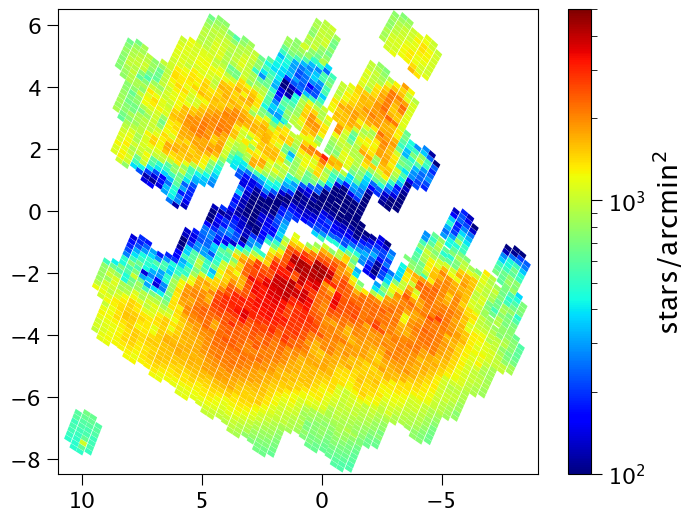

In [5]:
fig,ax=plt.subplots(figsize=(8,6))
patches=[]
sf_cols = []
for idx in ogle_rates.index:
    f,ra,dec=idx, ogle_rates['RAdeg'][idx],ogle_rates['DEdeg'][idx],
    for j in range(1,33):
        sbf_name = f+'.'+str(j).zfill(2)
        p = Polygon(np.column_stack(ogle_utils.equatorial_to_galactic(*ogle_utils.o4_subfield(ra,dec,j))),closed=True)
        try:
            dat = ogle_surfdens.at[sbf_name, 'sigma21']
            patches.append(p)
            sf_cols.append(dat)
        except:
            pass
norm = colors.LogNorm(vmin=100, vmax=5000)
pc = PatchCollection(patches, cmap='jet', norm=norm)
pc.set_array(sf_cols)
pc.set_edgecolor('none')
ax.add_collection(pc)

cbar = plt.colorbar(pc,label=r'stars/arcmin$^2$')
plt.xlim(11,-9)
plt.ylim(-8.5,6.5)

In [6]:
sum(ogle_rates.use_for_latdep)

38

In [7]:
pts = ogle_rates[['GLON','GLAT']][ogle_rates['use_for_latdep']].sort_values('GLAT')

In [9]:
import synthpop as sp
sp_lens = sp.SynthPop(default_config='macy_defaults.synthpop_conf',
                      model_name="Huston2025", name_for_output='lens',
                     maglim=['Bessell_I', 21,"keep"], output_location="outputfiles/ogle",
                     extinction_map_kwargs={"name":"surot"})
sp_src  = sp.SynthPop(default_config='macy_defaults.synthpop_conf',
                      model_name="Huston2025", name_for_output='src',
                     maglim=['Bessell_I', 21,"remove"], output_location="outputfiles/ogle",
                     extinction_map_kwargs={"name":"surot"})
sp_lens.init_populations()
sp_src.init_populations()



################################ Settings #################################
 94822 - # reading default parameters from
 94824 - default_config_file =  /u/mhuston/code/synthpop/synthpop/config_files/macy_defaults.synthpop_conf 


# copy the following to a config file to redo this model generation -------
 94834 - {
    "l_set": null,
    "l_set_type": null,
    "b_set": null,
    "b_set_type": null,
    "random_seed": 366688668,
    "name_for_output": "lens",
    "model_name": "Huston2024",
    "solid_angle": null,
    "solid_angle_unit": "deg^2",
    "sun": {
        "x": -8.178,
        "y": 0.0,
        "z": 0.017,
        "u": 12.9,
        "v": 245.6,
        "w": 7.78,
        "l_apex_deg": 56.24,
        "b_apex_deg": 22.54
    },
    "lsr": {
        "u_lsr": 1.8,
        "v_lsr": 233.4,
        "w_lsr": 0.53
    },
    "warp": {
        "r_warp": 7.72,
        "amp_warp": 0.06,
        "amp_warp_pos": null,
        "amp_warp_neg": null,
        "alpha_warp": 1.33,
        "ph

In [12]:
ulim = 20000
llim = 8000
alim = 12000
solang = 4e-4
for pt in range(len(pts)):
    l,b=pts['GLON'][pt], pts['GLAT'][pt]
    df1,_ = sp_lens.process_location(l_deg=l, b_deg=b, solid_angle=solang)
    leng = len(np.array(df1['W146']))
    if leng>ulim or leng<llim:
        print('    length:',leng,", rerunning l=",l,' b=',b)
        solang = solang * alim/leng
        df1,_ = sp_lens.process_location(l_deg=l, b_deg=b, solid_angle=solang)
        leng = len(np.array(df1['W146']))
    solang = solang * alim/leng



############################# update location #############################
 458699 - # set location to: 
 458702 - l, b = (-0.93 deg, -7.70 deg)
 458705 - # set solid_angle to:
 458709 - solid_angle = 1.000e-05 deg^2


############################# Generate Field ##############################


# Population 0;  bulge ----------------------------------------------------
 471292 - # From density profile (number density)
 471294 - expected_total_iMass = 180.3841
 471298 - expected_total_eMass = 98.9178
 471302 - average_iMass_per_star = 0.5739
 471305 - mass_loss_correction = 0.5484
 471308 - n_expected_stars = 314.3314
 471314 - # Determine velocities when position are generated 
 471459 - # From Generated Field:
 471462 - generated_stars = 319
 471466 - generated_total_iMass = 137.2481
 471479 - generated_total_eMass = 98.8059
 471482 - det_mass_loss_corr = 0.7199
 471547 - # Done


# Population 1;  halo -----------------------------------------------------
 472259 - # From density 

    length: 349 , rerunning l= -0.9252  b= -7.7037




# Population 0;  bulge ----------------------------------------------------
 482648 - # From density profile (number density)
 482651 - expected_total_iMass = 6202.1732
 482655 - expected_total_eMass = 3401.1063
 482658 - average_iMass_per_star = 0.5739
 482661 - mass_loss_correction = 0.5484
 482665 - n_expected_stars = 10807.7038
 482671 - # Determine velocities when position are generated 
 483154 - # From Generated Field:
 483157 - generated_stars = 10820
 483161 - generated_total_iMass = 6287.9095
 483173 - generated_total_eMass = 3379.2132
 483177 - det_mass_loss_corr = 0.5374
 483266 - # Done


# Population 1;  halo -----------------------------------------------------
 484049 - # From density profile (number density)
 484053 - expected_total_iMass = 32.0145
 484057 - expected_total_eMass = 16.8898
 484060 - average_iMass_per_star = 0.5739
 484064 - mass_loss_correction = 0.5276
 484068 - n_expected_stars = 55.7874
 484075 - # Determine velocities when position are generated 


    length: 7436 , rerunning l= 0.0082  b= 5.4341




# Population 0;  bulge ----------------------------------------------------
 993695 - # From density profile (number density)
 993698 - expected_total_iMass = 6386.5941
 993702 - expected_total_eMass = 3502.2378
 993705 - average_iMass_per_star = 0.5739
 993709 - mass_loss_correction = 0.5484
 993713 - n_expected_stars = 11129.0696
 993719 - # Determine velocities when position are generated 
 994217 - # From Generated Field:
 994220 - generated_stars = 10955
 994224 - generated_total_iMass = 6022.4480
 994235 - generated_total_eMass = 3458.1739
 994239 - det_mass_loss_corr = 0.5742
 994324 - # Done


# Population 1;  halo -----------------------------------------------------
 994939 - # From density profile (number density)
 994943 - expected_total_iMass = 16.9213
 994946 - expected_total_eMass = 8.9271
 994949 - average_iMass_per_star = 0.5739
 994953 - mass_loss_correction = 0.5276
 994957 - n_expected_stars = 29.4865
 994964 - # Determine velocities when position are generated 
 

In [13]:
for pt in range(len(pts)):
    l,b=pts['GLON'][pt], pts['GLAT'][pt]
    df1,_ = sp_src.process_location(l_deg=l, b_deg=b, solid_angle=solang)
    leng = len(np.array(df1['W146']))
    if leng>ulim or leng<llim:
        print('    length:',leng,", rerunning l=",l,' b=',b)
        solang = solang * alim/leng
        df1,_ = sp_src.process_location(l_deg=l, b_deg=b, solid_angle=solang)
        leng = len(np.array(df1['W146']))
    solang = solang * alim/leng



############################# update location #############################
 1026679 - # set location to: 
 1026685 - l, b = (-0.93 deg, -7.70 deg)
 1026689 - # set solid_angle to:
 1026693 - solid_angle = 1.146e-04 deg^2


############################# Generate Field ##############################


# Population 0;  bulge ----------------------------------------------------
 1039170 - # From density profile (number density)
 1039173 - expected_total_iMass = 2084.3123
 1039176 - expected_total_eMass = 1133.7845
 1039180 - average_iMass_per_star = 0.5739
 1039183 - mass_loss_correction = 0.5440
 1039186 - n_expected_stars = 3632.0543
 1039192 - # Determine velocities when position are generated 
 1039424 - # From Generated Field:
 1039427 - generated_stars = 309
 1039431 - generated_total_iMass = 250.5091
 1039472 - generated_total_eMass = 250.3602
 1039476 - det_mass_loss_corr = 0.9994
 1039560 - # Done


# Population 1;  halo -----------------------------------------------------
 10

    length: 361 , rerunning l= -0.9252  b= -7.7037




# Population 0;  bulge ----------------------------------------------------
 1050271 - # From density profile (number density)
 1050274 - expected_total_iMass = 69281.3306
 1050277 - expected_total_eMass = 37686.3372
 1050280 - average_iMass_per_star = 0.5739
 1050283 - mass_loss_correction = 0.5440
 1050287 - n_expected_stars = 120727.3758
 1050292 - # Determine velocities when position are generated 
 1054181 - # From Generated Field:
 1054185 - generated_stars = 9445
 1054188 - generated_total_iMass = 7624.6083
 1054201 - generated_total_eMass = 7620.0339
 1054204 - det_mass_loss_corr = 0.9994
 1054280 - # Done


# Population 1;  halo -----------------------------------------------------
 1054953 - # From density profile (number density)
 1054957 - expected_total_iMass = 355.8158
 1054960 - expected_total_eMass = 187.1389
 1054964 - average_iMass_per_star = 0.5739
 1054967 - mass_loss_correction = 0.5259
 1054970 - n_expected_stars = 620.0330
 1054976 - # Determine velocities when

  0%|          | 0/262151 [00:00<?, ?it/s]

 1241246 - # From Generated Field:
 1241249 - generated_stars = 15062
 1241253 - generated_total_iMass = 12911.9752
 1241267 - generated_total_eMass = 12901.7286
 1241271 - det_mass_loss_corr = 0.9992
 1241360 - # Done


# Population 1;  halo -----------------------------------------------------
 1241971 - # From density profile (number density)
 1241975 - expected_total_iMass = 365.9296
 1241978 - expected_total_eMass = 192.4581
 1241982 - average_iMass_per_star = 0.5739
 1241985 - mass_loss_correction = 0.5259
 1241988 - n_expected_stars = 637.6569
 1241994 - # Determine velocities when position are generated 
 1242158 - # From Generated Field:
 1242161 - generated_stars = 40
 1242165 - generated_total_iMass = 25.3376
 1242175 - generated_total_eMass = 25.3477
 1242179 - det_mass_loss_corr = 1.0004
 1242256 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1242852 - # From density profile (number density)
 1242856 - expected_total_iMass = 4335.70

  0%|          | 0/294714 [00:00<?, ?it/s]

 1286619 - # From Generated Field:
 1286623 - generated_stars = 16707
 1286627 - generated_total_iMass = 14261.4078
 1286639 - generated_total_eMass = 14251.9054
 1286643 - det_mass_loss_corr = 0.9993
 1286741 - # Done


# Population 1;  halo -----------------------------------------------------
 1287357 - # From density profile (number density)
 1287361 - expected_total_iMass = 356.4117
 1287365 - expected_total_eMass = 187.4523
 1287368 - average_iMass_per_star = 0.5739
 1287371 - mass_loss_correction = 0.5259
 1287376 - n_expected_stars = 621.0714
 1287383 - # Determine velocities when position are generated 
 1287552 - # From Generated Field:
 1287555 - generated_stars = 32
 1287558 - generated_total_iMass = 21.3526
 1287569 - generated_total_eMass = 21.3079
 1287573 - det_mass_loss_corr = 0.9979
 1287666 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1288280 - # From density profile (number density)
 1288284 - expected_total_iMass = 4317.29

  0%|          | 0/279683 [00:00<?, ?it/s]

 1331832 - # From Generated Field:
 1331835 - generated_stars = 11482
 1331838 - generated_total_iMass = 10316.6255
 1331852 - generated_total_eMass = 10307.7517
 1331856 - det_mass_loss_corr = 0.9991
 1331945 - # Done


# Population 1;  halo -----------------------------------------------------
 1332597 - # From density profile (number density)
 1332622 - expected_total_iMass = 305.4126
 1332626 - expected_total_eMass = 160.6296
 1332636 - average_iMass_per_star = 0.5739
 1332640 - mass_loss_correction = 0.5259
 1332643 - n_expected_stars = 532.2020
 1332651 - # Determine velocities when position are generated 
 1332826 - # From Generated Field:
 1332829 - generated_stars = 20
 1332833 - generated_total_iMass = 13.6561
 1332844 - generated_total_eMass = 13.6511
 1332848 - det_mass_loss_corr = 0.9996
 1332936 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1333582 - # From density profile (number density)
 1333587 - expected_total_iMass = 3605.41

  0%|          | 0/316250 [00:00<?, ?it/s]

 1356651 - # From Generated Field:
 1356655 - generated_stars = 18601
 1356659 - generated_total_iMass = 15855.9037
 1356671 - generated_total_eMass = 15844.2338
 1356675 - det_mass_loss_corr = 0.9993
 1356775 - # Done


# Population 1;  halo -----------------------------------------------------
 1357383 - # From density profile (number density)
 1357387 - expected_total_iMass = 348.2558
 1357390 - expected_total_eMass = 183.1627
 1357394 - average_iMass_per_star = 0.5739
 1357397 - mass_loss_correction = 0.5259
 1357401 - n_expected_stars = 606.8591
 1357408 - # Determine velocities when position are generated 
 1357574 - # From Generated Field:
 1357578 - generated_stars = 25
 1357581 - generated_total_iMass = 16.5767
 1357592 - generated_total_eMass = 16.5714
 1357596 - det_mass_loss_corr = 0.9997
 1357717 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1358335 - # From density profile (number density)
 1358339 - expected_total_iMass = 3627.10

    length: 20569 , rerunning l= 1.1399  b= -3.7432




# Population 0;  bulge ----------------------------------------------------
 1372210 - # From density profile (number density)
 1372214 - expected_total_iMass = 106099.4709
 1372217 - expected_total_eMass = 57713.9671
 1372220 - average_iMass_per_star = 0.5739
 1372224 - mass_loss_correction = 0.5440
 1372228 - n_expected_stars = 184885.4603
 1372234 - # Determine velocities when position are generated 
 1378205 - # From Generated Field:
 1378209 - generated_stars = 10774
 1378213 - generated_total_iMass = 9166.2113
 1378225 - generated_total_eMass = 9160.3039
 1378232 - det_mass_loss_corr = 0.9994
 1378327 - # Done


# Population 1;  halo -----------------------------------------------------
 1378952 - # From density profile (number density)
 1378956 - expected_total_iMass = 203.1403
 1378959 - expected_total_eMass = 106.8402
 1378963 - average_iMass_per_star = 0.5739
 1378966 - mass_loss_correction = 0.5259
 1378970 - n_expected_stars = 353.9856
 1378976 - # Determine velocities wh

  0%|          | 0/303260 [00:00<?, ?it/s]

 1423693 - # From Generated Field:
 1423697 - generated_stars = 17236
 1423700 - generated_total_iMass = 14737.3521
 1423713 - generated_total_eMass = 14727.5422
 1423741 - det_mass_loss_corr = 0.9993
 1423846 - # Done


# Population 1;  halo -----------------------------------------------------
 1424474 - # From density profile (number density)
 1424477 - expected_total_iMass = 304.8838
 1424481 - expected_total_eMass = 160.3515
 1424484 - average_iMass_per_star = 0.5739
 1424487 - mass_loss_correction = 0.5259
 1424492 - n_expected_stars = 531.2806
 1424498 - # Determine velocities when position are generated 
 1424648 - # From Generated Field:
 1424652 - generated_stars = 17
 1424655 - generated_total_iMass = 11.7325
 1424665 - generated_total_eMass = 11.6921
 1424669 - det_mass_loss_corr = 0.9966
 1424758 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1425372 - # From density profile (number density)
 1425376 - expected_total_iMass = 3249.39

  0%|          | 0/275574 [00:00<?, ?it/s]

 1471045 - # From Generated Field:
 1471049 - generated_stars = 7623
 1471053 - generated_total_iMass = 7133.8282
 1471065 - generated_total_eMass = 7125.6024
 1471068 - det_mass_loss_corr = 0.9988
 1471148 - # Done


# Population 1;  halo -----------------------------------------------------
 1471799 - # From density profile (number density)
 1471802 - expected_total_iMass = 245.0924
 1471806 - expected_total_eMass = 128.9046
 1471809 - average_iMass_per_star = 0.5739
 1471812 - mass_loss_correction = 0.5259
 1471815 - n_expected_stars = 427.0899
 1471821 - # Determine velocities when position are generated 
 1471991 - # From Generated Field:
 1471995 - generated_stars = 6
 1471998 - generated_total_iMass = 4.3177
 1472009 - generated_total_eMass = 4.3157
 1472013 - det_mass_loss_corr = 0.9995
 1472093 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1472741 - # From density profile (number density)
 1472746 - expected_total_iMass = 2524.1512
 14

  0%|          | 0/445811 [00:00<?, ?it/s]

 1500134 - # From Generated Field:
 1500137 - generated_stars = 20719
 1500141 - generated_total_iMass = 18231.8317
 1500153 - generated_total_eMass = 18217.1701
 1500158 - det_mass_loss_corr = 0.9992
 1500266 - # Done


# Population 1;  halo -----------------------------------------------------
 1500948 - # From density profile (number density)
 1500952 - expected_total_iMass = 460.0310
 1500956 - expected_total_eMass = 241.9501
 1500960 - average_iMass_per_star = 0.5739
 1500963 - mass_loss_correction = 0.5259
 1500967 - n_expected_stars = 801.6349
 1500974 - # Determine velocities when position are generated 
 1501180 - # From Generated Field:
 1501184 - generated_stars = 38
 1501187 - generated_total_iMass = 25.7782
 1501199 - generated_total_eMass = 25.7693
 1501203 - det_mass_loss_corr = 0.9997
 1501297 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1501953 - # From density profile (number density)
 1501958 - expected_total_iMass = 3660.42

    length: 24196 , rerunning l= 1.087  b= -2.389




# Population 0;  bulge ----------------------------------------------------
 1518298 - # From density profile (number density)
 1518302 - expected_total_iMass = 126779.8479
 1518305 - expected_total_eMass = 68963.2843
 1518308 - average_iMass_per_star = 0.5739
 1518311 - mass_loss_correction = 0.5440
 1518314 - n_expected_stars = 220922.4075
 1518321 - # Determine velocities when position are generated 
 1525864 - # From Generated Field:
 1525868 - generated_stars = 10597
 1525872 - generated_total_iMass = 9304.7758
 1525886 - generated_total_eMass = 9297.7094
 1525890 - det_mass_loss_corr = 0.9992
 1525985 - # Done


# Population 1;  halo -----------------------------------------------------
 1526743 - # From density profile (number density)
 1526749 - expected_total_iMass = 228.1298
 1526753 - expected_total_eMass = 119.9833
 1526756 - average_iMass_per_star = 0.5739
 1526760 - mass_loss_correction = 0.5259
 1526764 - n_expected_stars = 397.5315
 1526771 - # Determine velocities wh

  0%|          | 0/301739 [00:00<?, ?it/s]

 1577809 - # From Generated Field:
 1577812 - generated_stars = 11514
 1577815 - generated_total_iMass = 10341.5885
 1577827 - generated_total_eMass = 10332.0571
 1577831 - det_mass_loss_corr = 0.9991
 1577917 - # Done


# Population 1;  halo -----------------------------------------------------
 1578652 - # From density profile (number density)
 1578655 - expected_total_iMass = 292.9274
 1578659 - expected_total_eMass = 154.0631
 1578662 - average_iMass_per_star = 0.5739
 1578666 - mass_loss_correction = 0.5259
 1578669 - n_expected_stars = 510.4456
 1578676 - # Determine velocities when position are generated 
 1578838 - # From Generated Field:
 1578842 - generated_stars = 13
 1578846 - generated_total_iMass = 9.4155
 1578856 - generated_total_eMass = 9.4095
 1578860 - det_mass_loss_corr = 0.9994
 1578948 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1579646 - # From density profile (number density)
 1579650 - expected_total_iMass = 2580.2016

  0%|          | 0/332679 [00:00<?, ?it/s]

 1607034 - # From Generated Field:
 1607037 - generated_stars = 11939
 1607041 - generated_total_iMass = 10724.5526
 1607053 - generated_total_eMass = 10713.3786
 1607057 - det_mass_loss_corr = 0.9990
 1607154 - # Done


# Population 1;  halo -----------------------------------------------------
 1607789 - # From density profile (number density)
 1607793 - expected_total_iMass = 272.6326
 1607797 - expected_total_eMass = 143.3892
 1607800 - average_iMass_per_star = 0.5739
 1607804 - mass_loss_correction = 0.5259
 1607808 - n_expected_stars = 475.0806
 1607815 - # Determine velocities when position are generated 
 1607985 - # From Generated Field:
 1607989 - generated_stars = 5
 1607993 - generated_total_iMass = 3.6336
 1608003 - generated_total_eMass = 3.6314
 1608007 - det_mass_loss_corr = 0.9994
 1608097 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1608746 - # From density profile (number density)
 1608749 - expected_total_iMass = 2159.0941


  0%|          | 0/319023 [00:00<?, ?it/s]

 1635170 - # From Generated Field:
 1635173 - generated_stars = 8651
 1635176 - generated_total_iMass = 7958.4724
 1635188 - generated_total_eMass = 7949.5658
 1635191 - det_mass_loss_corr = 0.9989
 1635268 - # Done


# Population 1;  halo -----------------------------------------------------
 1635929 - # From density profile (number density)
 1635932 - expected_total_iMass = 230.6874
 1635936 - expected_total_eMass = 121.3284
 1635939 - average_iMass_per_star = 0.5739
 1635942 - mass_loss_correction = 0.5259
 1635945 - n_expected_stars = 401.9883
 1635950 - # Determine velocities when position are generated 
 1636093 - # From Generated Field:
 1636096 - generated_stars = 1
 1636100 - generated_total_iMass = 0.7796
 1636110 - generated_total_eMass = 0.7789
 1636114 - det_mass_loss_corr = 0.9991
 1636187 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1636834 - # From density profile (number density)
 1636837 - expected_total_iMass = 2023.7056
 16

  0%|          | 0/253061 [00:00<?, ?it/s]

 1691237 - # From Generated Field:
 1691242 - generated_stars = 7036
 1691246 - generated_total_iMass = 6601.7743
 1691263 - generated_total_eMass = 6594.0218
 1691267 - det_mass_loss_corr = 0.9988
 1691360 - # Done


# Population 1;  halo -----------------------------------------------------
 1691976 - # From density profile (number density)
 1691980 - expected_total_iMass = 199.1897
 1691983 - expected_total_eMass = 104.7625
 1691987 - average_iMass_per_star = 0.5739
 1691991 - mass_loss_correction = 0.5259
 1691994 - n_expected_stars = 347.1015
 1692001 - # Determine velocities when position are generated 
 1692194 - # From Generated Field:
 1692198 - generated_stars = 10
 1692203 - generated_total_iMass = 7.0213
 1692213 - generated_total_eMass = 7.0452
 1692217 - det_mass_loss_corr = 1.0034
 1692306 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1692926 - # From density profile (number density)
 1692929 - expected_total_iMass = 1834.0679
 1

  0%|          | 0/291168 [00:00<?, ?it/s]

 1717817 - # From Generated Field:
 1717821 - generated_stars = 6677
 1717825 - generated_total_iMass = 6326.7937
 1717837 - generated_total_eMass = 6317.6748
 1717841 - det_mass_loss_corr = 0.9986
 1717928 - # Done


# Population 1;  halo -----------------------------------------------------
 1718531 - # From density profile (number density)
 1718535 - expected_total_iMass = 252.4124
 1718538 - expected_total_eMass = 132.7545
 1718542 - average_iMass_per_star = 0.5739
 1718545 - mass_loss_correction = 0.5259
 1718548 - n_expected_stars = 439.8455
 1718579 - # Determine velocities when position are generated 
 1718736 - # From Generated Field:
 1718740 - generated_stars = 7
 1718744 - generated_total_iMass = 5.2037
 1718754 - generated_total_eMass = 5.2003
 1718758 - det_mass_loss_corr = 0.9993
 1718848 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1719492 - # From density profile (number density)
 1719495 - expected_total_iMass = 2094.4199
 17

  0%|          | 0/338351 [00:00<?, ?it/s]

 1745585 - # From Generated Field:
 1745588 - generated_stars = 6645
 1745592 - generated_total_iMass = 6320.3885
 1745636 - generated_total_eMass = 6310.7184
 1745640 - det_mass_loss_corr = 0.9985
 1745725 - # Done


# Population 1;  halo -----------------------------------------------------
 1746361 - # From density profile (number density)
 1746365 - expected_total_iMass = 305.6486
 1746368 - expected_total_eMass = 160.7538
 1746372 - average_iMass_per_star = 0.5739
 1746375 - mass_loss_correction = 0.5259
 1746379 - n_expected_stars = 532.6133
 1746386 - # Determine velocities when position are generated 
 1746549 - # From Generated Field:
 1746553 - generated_stars = 10
 1746556 - generated_total_iMass = 6.9898
 1746567 - generated_total_eMass = 6.9869
 1746570 - det_mass_loss_corr = 0.9996
 1746660 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1747303 - # From density profile (number density)
 1747306 - expected_total_iMass = 2478.1009
 1

  0%|          | 0/343002 [00:00<?, ?it/s]

 1773248 - # From Generated Field:
 1773251 - generated_stars = 6646
 1773255 - generated_total_iMass = 6338.1276
 1773268 - generated_total_eMass = 6328.6033
 1773272 - det_mass_loss_corr = 0.9985
 1773364 - # Done


# Population 1;  halo -----------------------------------------------------
 1773985 - # From density profile (number density)
 1773989 - expected_total_iMass = 345.1370
 1773992 - expected_total_eMass = 181.5224
 1774020 - average_iMass_per_star = 0.5739
 1774032 - mass_loss_correction = 0.5259
 1774036 - n_expected_stars = 601.4245
 1774042 - # Determine velocities when position are generated 
 1774231 - # From Generated Field:
 1774235 - generated_stars = 18
 1774238 - generated_total_iMass = 12.9211
 1774249 - generated_total_eMass = 12.9224
 1774253 - det_mass_loss_corr = 1.0001
 1774338 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1774961 - # From density profile (number density)
 1774965 - expected_total_iMass = 3115.6132


  0%|          | 0/404425 [00:00<?, ?it/s]

 1802908 - # From Generated Field:
 1802911 - generated_stars = 6948
 1802915 - generated_total_iMass = 6670.2035
 1802926 - generated_total_eMass = 6657.6768
 1802930 - det_mass_loss_corr = 0.9981
 1803060 - # Done


# Population 1;  halo -----------------------------------------------------
 1803796 - # From density profile (number density)
 1803801 - expected_total_iMass = 358.2752
 1803805 - expected_total_eMass = 188.4323
 1803809 - average_iMass_per_star = 0.5739
 1803812 - mass_loss_correction = 0.5259
 1803816 - n_expected_stars = 624.3186
 1803823 - # Determine velocities when position are generated 
 1803999 - # From Generated Field:
 1804003 - generated_stars = 7
 1804006 - generated_total_iMass = 5.1750
 1804016 - generated_total_eMass = 5.1719
 1804020 - det_mass_loss_corr = 0.9994
 1804106 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1804837 - # From density profile (number density)
 1804841 - expected_total_iMass = 3636.7407
 18

  0%|          | 0/505415 [00:00<?, ?it/s]

 1836257 - # From Generated Field:
 1836261 - generated_stars = 15106
 1836264 - generated_total_iMass = 13936.3189
 1836277 - generated_total_eMass = 13920.1833
 1836281 - det_mass_loss_corr = 0.9988
 1836367 - # Done


# Population 1;  halo -----------------------------------------------------
 1837066 - # From density profile (number density)
 1837069 - expected_total_iMass = 531.7320
 1837072 - expected_total_eMass = 279.6607
 1837075 - average_iMass_per_star = 0.5739
 1837079 - mass_loss_correction = 0.5259
 1837082 - n_expected_stars = 926.5787
 1837087 - # Determine velocities when position are generated 
 1837261 - # From Generated Field:
 1837264 - generated_stars = 18
 1837268 - generated_total_iMass = 12.8702
 1837278 - generated_total_eMass = 12.8786
 1837282 - det_mass_loss_corr = 1.0007
 1837361 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1838089 - # From density profile (number density)
 1838093 - expected_total_iMass = 4572.25

  0%|          | 0/268878 [00:00<?, ?it/s]

 1863046 - # From Generated Field:
 1863049 - generated_stars = 9884
 1863053 - generated_total_iMass = 8964.0146
 1863064 - generated_total_eMass = 8956.2185
 1863068 - det_mass_loss_corr = 0.9991
 1863162 - # Done


# Population 1;  halo -----------------------------------------------------
 1863763 - # From density profile (number density)
 1863768 - expected_total_iMass = 264.0633
 1863772 - expected_total_eMass = 138.8823
 1863776 - average_iMass_per_star = 0.5739
 1863779 - mass_loss_correction = 0.5259
 1863783 - n_expected_stars = 460.1481
 1863790 - # Determine velocities when position are generated 
 1863963 - # From Generated Field:
 1863967 - generated_stars = 3
 1863970 - generated_total_iMass = 2.2283
 1863981 - generated_total_eMass = 2.2267
 1863985 - det_mass_loss_corr = 0.9993
 1864081 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1864706 - # From density profile (number density)
 1864710 - expected_total_iMass = 2947.2093
 18

  0%|          | 0/264268 [00:00<?, ?it/s]

 1886839 - # From Generated Field:
 1886842 - generated_stars = 7866
 1886846 - generated_total_iMass = 7312.7553
 1886861 - generated_total_eMass = 7304.1240
 1886864 - det_mass_loss_corr = 0.9988
 1886970 - # Done


# Population 1;  halo -----------------------------------------------------
 1887634 - # From density profile (number density)
 1887639 - expected_total_iMass = 269.0194
 1887642 - expected_total_eMass = 141.4889
 1887646 - average_iMass_per_star = 0.5739
 1887650 - mass_loss_correction = 0.5259
 1887653 - n_expected_stars = 468.7844
 1887660 - # Determine velocities when position are generated 
 1887822 - # From Generated Field:
 1887826 - generated_stars = 5
 1887830 - generated_total_iMass = 3.6857
 1887841 - generated_total_eMass = 3.6837
 1887845 - det_mass_loss_corr = 0.9995
 1887934 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1888561 - # From density profile (number density)
 1888565 - expected_total_iMass = 2720.1872
 18

  0%|          | 0/308025 [00:00<?, ?it/s]

 1911300 - # From Generated Field:
 1911303 - generated_stars = 3127
 1911306 - generated_total_iMass = 3103.7312
 1911318 - generated_total_eMass = 3095.7391
 1911322 - det_mass_loss_corr = 0.9974
 1911415 - # Done


# Population 1;  halo -----------------------------------------------------
 1912115 - # From density profile (number density)
 1912121 - expected_total_iMass = 329.8486
 1912124 - expected_total_eMass = 173.4816
 1912128 - average_iMass_per_star = 0.5739
 1912131 - mass_loss_correction = 0.5259
 1912134 - n_expected_stars = 574.7833
 1912140 - # Determine velocities when position are generated 
 1912311 - # From Generated Field:
 1912315 - generated_stars = 1
 1912319 - generated_total_iMass = 0.7697
 1912329 - generated_total_eMass = 0.7678
 1912333 - det_mass_loss_corr = 0.9976
 1912418 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1913133 - # From density profile (number density)
 1913136 - expected_total_iMass = 3472.9148
 19

    length: 4584 , rerunning l= 1.3523  b= 3.4996




# Population 0;  bulge ----------------------------------------------------
 1926188 - # From density profile (number density)
 1926191 - expected_total_iMass = 464031.3237
 1926222 - expected_total_eMass = 252414.9117
 1926234 - average_iMass_per_star = 0.5739
 1926238 - mass_loss_correction = 0.5440
 1926241 - n_expected_stars = 808605.7749
 1926247 - # Determine velocities when position are generated 


  0%|          | 0/807606 [00:00<?, ?it/s]

 1952566 - # From Generated Field:
 1952569 - generated_stars = 4436
 1952572 - generated_total_iMass = 4439.2240
 1952585 - generated_total_eMass = 4419.7973
 1952588 - det_mass_loss_corr = 0.9956
 1952666 - # Done


# Population 1;  halo -----------------------------------------------------
 1953307 - # From density profile (number density)
 1953310 - expected_total_iMass = 863.3891
 1953314 - expected_total_eMass = 454.0935
 1953317 - average_iMass_per_star = 0.5739
 1953320 - mass_loss_correction = 0.5259
 1953323 - n_expected_stars = 1504.5136
 1953329 - # Determine velocities when position are generated 
 1953519 - # From Generated Field:
 1953523 - generated_stars = 10
 1953526 - generated_total_iMass = 7.5633
 1953537 - generated_total_eMass = 7.5196
 1953540 - det_mass_loss_corr = 0.9942
 1953620 - # Done


# Population 2;  thick_disk -----------------------------------------------
 1954274 - # From density profile (number density)
 1954279 - expected_total_iMass = 9091.3787
 

  0%|          | 0/861288 [00:00<?, ?it/s]

 1999342 - # From Generated Field:
 1999345 - generated_stars = 19470
 1999348 - generated_total_iMass = 18500.8602
 1999362 - generated_total_eMass = 18475.0423
 1999366 - det_mass_loss_corr = 0.9986
 1999463 - # Done


# Population 1;  halo -----------------------------------------------------
 2000108 - # From density profile (number density)
 2000112 - expected_total_iMass = 906.6009
 2000115 - expected_total_eMass = 476.8204
 2000118 - average_iMass_per_star = 0.5739
 2000121 - mass_loss_correction = 0.5259
 2000124 - n_expected_stars = 1579.8130
 2000131 - # Determine velocities when position are generated 
 2000353 - # From Generated Field:
 2000357 - generated_stars = 35
 2000360 - generated_total_iMass = 24.5858
 2000371 - generated_total_eMass = 24.5730
 2000374 - det_mass_loss_corr = 0.9995
 2000459 - # Done


# Population 2;  thick_disk -----------------------------------------------
 2001098 - # From density profile (number density)
 2001102 - expected_total_iMass = 10943.

    length: 24192 , rerunning l= -2.2382  b= 4.0765




# Population 0;  bulge ----------------------------------------------------
 2018207 - # From density profile (number density)
 2018210 - expected_total_iMass = 245399.4304
 2018213 - expected_total_eMass = 133487.7030
 2018216 - average_iMass_per_star = 0.5739
 2018219 - mass_loss_correction = 0.5440
 2018222 - n_expected_stars = 427625.0037
 2018229 - # Determine velocities when position are generated 


  0%|          | 0/427232 [00:00<?, ?it/s]

 2032061 - # From Generated Field:
 2032064 - generated_stars = 10030
 2032068 - generated_total_iMass = 9501.1413
 2032080 - generated_total_eMass = 9488.4995
 2032083 - det_mass_loss_corr = 0.9987
 2032178 - # Done


# Population 1;  halo -----------------------------------------------------
 2032834 - # From density profile (number density)
 2032839 - expected_total_iMass = 449.7352
 2032842 - expected_total_eMass = 236.5351
 2032846 - average_iMass_per_star = 0.5739
 2032849 - mass_loss_correction = 0.5259
 2032852 - n_expected_stars = 783.6938
 2032860 - # Determine velocities when position are generated 
 2033033 - # From Generated Field:
 2033036 - generated_stars = 20
 2033040 - generated_total_iMass = 14.3436
 2033051 - generated_total_eMass = 14.3121
 2033055 - det_mass_loss_corr = 0.9978
 2033135 - # Done


# Population 2;  thick_disk -----------------------------------------------
 2033798 - # From density profile (number density)
 2033801 - expected_total_iMass = 5428.2212

  0%|          | 0/405967 [00:00<?, ?it/s]

 2060825 - # From Generated Field:
 2060828 - generated_stars = 2036
 2060831 - generated_total_iMass = 2059.2858
 2060843 - generated_total_eMass = 2049.9217
 2060846 - det_mass_loss_corr = 0.9955
 2060921 - # Done


# Population 1;  halo -----------------------------------------------------
 2061703 - # From density profile (number density)
 2061706 - expected_total_iMass = 475.7710
 2061710 - expected_total_eMass = 250.2285
 2061713 - average_iMass_per_star = 0.5739
 2061716 - mass_loss_correction = 0.5259
 2061719 - n_expected_stars = 829.0630
 2061725 - # Determine velocities when position are generated 
 2061912 - # From Generated Field:
 2061916 - generated_stars = 2
 2061919 - generated_total_iMass = 1.5279
 2061930 - generated_total_eMass = 1.5267
 2061933 - det_mass_loss_corr = 0.9992
 2062011 - # Done


# Population 2;  thick_disk -----------------------------------------------
 2062792 - # From density profile (number density)
 2062796 - expected_total_iMass = 5225.6244
 20

    length: 3358 , rerunning l= 0.1737  b= 4.1858




# Population 0;  bulge ----------------------------------------------------
 2076635 - # From density profile (number density)
 2076639 - expected_total_iMass = 832639.5126
 2076642 - expected_total_eMass = 452923.3659
 2076645 - average_iMass_per_star = 0.5739
 2076648 - mass_loss_correction = 0.5440
 2076652 - n_expected_stars = 1450930.3228
 2076658 - # Determine velocities when position are generated 


  0%|          | 0/1450557 [00:00<?, ?it/s]

 2123277 - # From Generated Field:
 2123280 - generated_stars = 5118
 2123283 - generated_total_iMass = 5158.7939
 2123295 - generated_total_eMass = 5123.8842
 2123299 - det_mass_loss_corr = 0.9932
 2123392 - # Done


# Population 1;  halo -----------------------------------------------------
 2124038 - # From density profile (number density)
 2124042 - expected_total_iMass = 1700.0822
 2124046 - expected_total_eMass = 894.1464
 2124050 - average_iMass_per_star = 0.5739
 2124054 - mass_loss_correction = 0.5259
 2124058 - n_expected_stars = 2962.5074
 2124065 - # Determine velocities when position are generated 
 2124321 - # From Generated Field:
 2124324 - generated_stars = 11
 2124329 - generated_total_iMass = 8.3842
 2124339 - generated_total_eMass = 8.4245
 2124344 - det_mass_loss_corr = 1.0048
 2124433 - # Done


# Population 2;  thick_disk -----------------------------------------------
 2125058 - # From density profile (number density)
 2125062 - expected_total_iMass = 18674.5380

  0%|          | 0/1329986 [00:00<?, ?it/s]

 2187498 - # From Generated Field:
 2187501 - generated_stars = 8908
 2187504 - generated_total_iMass = 8895.9178
 2187516 - generated_total_eMass = 8861.1286
 2187520 - det_mass_loss_corr = 0.9961
 2187623 - # Done


# Population 1;  halo -----------------------------------------------------
 2188229 - # From density profile (number density)
 2188234 - expected_total_iMass = 1545.7907
 2188237 - expected_total_eMass = 812.9979
 2188241 - average_iMass_per_star = 0.5739
 2188245 - mass_loss_correction = 0.5259
 2188248 - n_expected_stars = 2693.6442
 2188256 - # Determine velocities when position are generated 
 2188511 - # From Generated Field:
 2188514 - generated_stars = 13
 2188518 - generated_total_iMass = 9.7049
 2188564 - generated_total_eMass = 9.6984
 2188568 - det_mass_loss_corr = 0.9993
 2188655 - # Done


# Population 2;  thick_disk -----------------------------------------------
 2189291 - # From density profile (number density)
 2189294 - expected_total_iMass = 19130.1704

  0%|          | 0/626724 [00:00<?, ?it/s]

 2229021 - # From Generated Field:
 2229024 - generated_stars = 13353
 2229028 - generated_total_iMass = 12752.1587
 2229040 - generated_total_eMass = 12733.2555
 2229044 - det_mass_loss_corr = 0.9985
 2229129 - # Done


# Population 1;  halo -----------------------------------------------------
 2229821 - # From density profile (number density)
 2229825 - expected_total_iMass = 948.2089
 2229828 - expected_total_eMass = 498.7039
 2229831 - average_iMass_per_star = 0.5739
 2229834 - mass_loss_correction = 0.5259
 2229837 - n_expected_stars = 1652.3178
 2229843 - # Determine velocities when position are generated 
 2230047 - # From Generated Field:
 2230050 - generated_stars = 33
 2230053 - generated_total_iMass = 23.4672
 2230098 - generated_total_eMass = 23.5114
 2230102 - det_mass_loss_corr = 1.0019
 2230178 - # Done


# Population 2;  thick_disk -----------------------------------------------
 2230851 - # From density profile (number density)
 2230855 - expected_total_iMass = 11459.

In [28]:
output_cols = ['l','b','n_source','n_lens','sa_source','sa_lens',
                  'avg_tau','avg_t','avg_theta',
                  'eventrate_area','eventrate_source',
                  'avg_ds','avg_dl',
                  'stdev_ds','stdev_dl','stdev_t',
                  'frac_bulge_lens', 'frac_disk_lens','frac_bulge_source','frac_disk_source']
len_dir = 'outputfiles/ogle/lens_'     #directory that the source and lens catalogs are in
src_dir = 'outputfiles/ogle/src_'      #directory that the source and lens catalogs are in
data_list = []
for pt in range(len(pts)):
    l,b=pts['GLON'][pt], pts['GLAT'][pt]
    dat,_ = microlensing_calculations.mulens_stats(len_dir,src_dir, l,b, outputs=output_cols)
    data_list.append(dat)
    print(*dat)
output = pd.DataFrame(data=data_list, columns=output_cols)
output.to_csv('mulens_rates_mock_ogle.txt', index=False)

['479678 - solid_angle = 3.438e-04 deg^2\n']
-0.9252 -7.7037 10981 11783 0.0038100000000000005 0.0003438 3.232846673145038e-07 32.915034456887994 2.1099994352952506e-09 6.577800487667301 2.282252969493891e-06 8.851619687760966 6.20557705871765 1.5788970965214424 2.0922688529785014 47.825573294701506 0.7496847609107086 0.24758531134743683 0.9176576020923467 0.07621701755085658
['493925 - solid_angle = 3.502e-04 deg^2\n']


KeyboardInterrupt: 

In [15]:
sp_dat = pd.read_csv('mulens_rates_mock_ogle.txt')
sp_dat.keys()

Index(['l', 'b', 'n_source', 'n_lens', 'sa_source', 'sa_lens', 'avg_tau',
       'avg_t', 'avg_theta', 'eventrate_area', 'eventrate_source', 'avg_ds',
       'avg_dl', 'stdev_ds', 'stdev_dl', 'stdev_t', 'frac_bulge_lens',
       'frac_disk_lens', 'frac_bulge_source', 'frac_disk_source'],
      dtype='object')

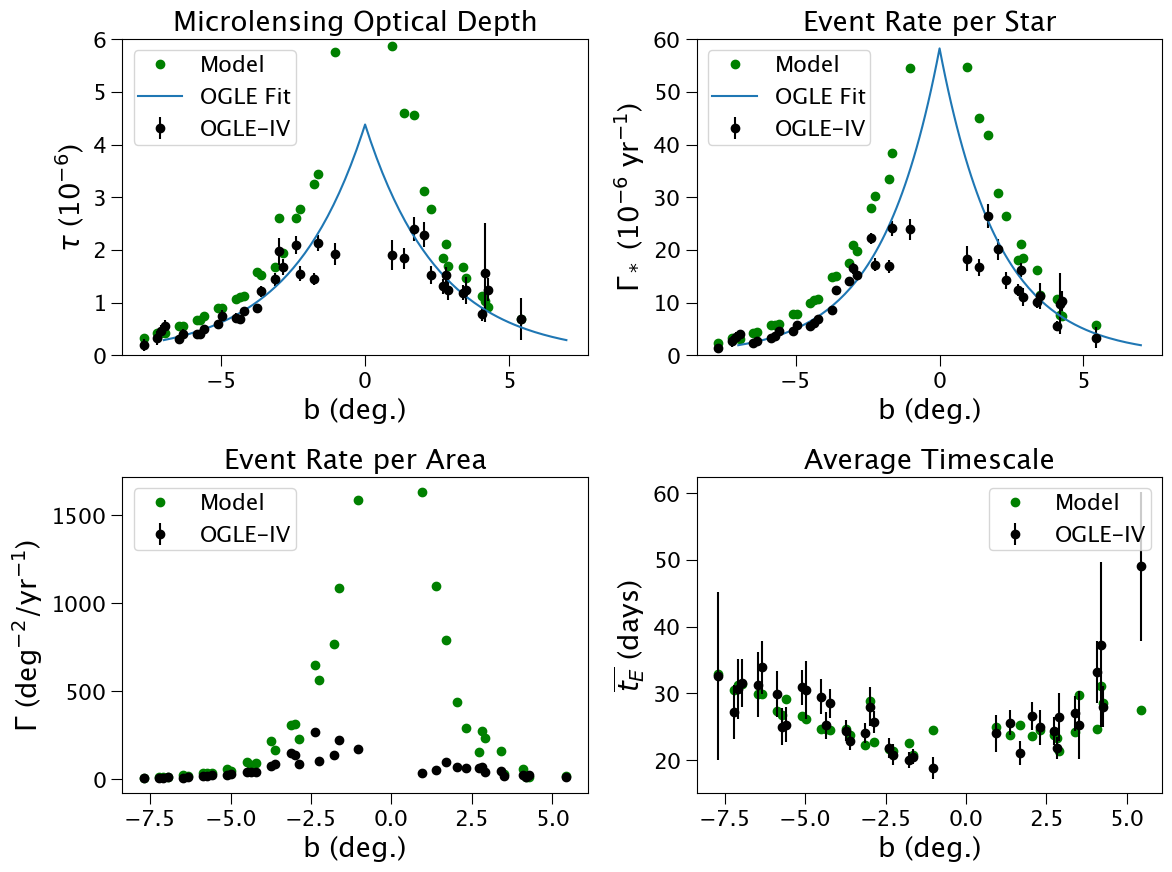

In [24]:
b_pts = np.arange(-7,7.0001,0.1)
def tau_fit(b):
    return 1.36 * np.exp(0.39*(3-abs(b)))
def rt_fit(b):
    return 13.4 * np.exp(0.49*(3-abs(b)))

modlab='Model'; oglab='OGLE-IV'
ogle_rates_sel = ogle_rates[ogle_rates['use_for_latdep']]

plt.subplots(nrows=2,ncols=2,figsize=(12,9))
plt.subplot(221)
plt.title('Microlensing Optical Depth')
plt.plot(sp_dat['b'], sp_dat['avg_tau']*10**6,'go',label=modlab)
plt.errorbar(ogle_rates_sel['GLAT'],ogle_rates_sel['tau'], yerr=ogle_rates_sel['e_tau'],linestyle='none',marker='o',c='k',label=oglab)
plt.plot(b_pts, tau_fit(b_pts),label='OGLE Fit')
plt.ylabel(r'$\tau$ (10$^{-6}$)'); plt.xlabel('b (deg.)')
plt.ylim(0,6)
plt.legend()

plt.subplot(222)
plt.title('Event Rate per Star')
plt.plot(sp_dat['b'], sp_dat['eventrate_source']*10**6,'go',label=modlab)
plt.errorbar(ogle_rates_sel['GLAT'],ogle_rates_sel['gam'], yerr=ogle_rates_sel['e_gam'],linestyle='none',marker='o',c='k',label=oglab)
plt.plot(b_pts, rt_fit(b_pts),label='OGLE Fit')
plt.ylabel(r'$\Gamma_*$ (10$^{-6}$ yr$^{-1}$)'); plt.xlabel('b (deg.)')
plt.ylim(0,60)
plt.legend()

plt.subplot(223)
plt.title('Event Rate per Area')
plt.plot(sp_dat['b'], sp_dat['eventrate_area'],'go',label=modlab)
plt.errorbar(ogle_rates_sel['GLAT'],ogle_rates_sel['gam-deg2'], yerr=ogle_rates_sel['e_gam-deg2'],linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel(r'$\Gamma$ (deg$^{-2}$/yr$^{-1}$)'); plt.xlabel('b (deg.)')
#plt.ylim(0,60)
plt.legend()

plt.subplot(224)
plt.title('Average Timescale')
plt.plot(sp_dat['b'], sp_dat['avg_t'],'go',label=modlab)
plt.errorbar(ogle_rates_sel['GLAT'],ogle_rates_sel['tE-mean'], yerr=ogle_rates_sel['e_tE-mean'],linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel('$\overline{t_E}$ (days)'); plt.xlabel('b (deg.)')
#plt.ylim(0,60)
plt.tight_layout()
plt.legend()

plt.savefig('figures/ogle_bdep.png')

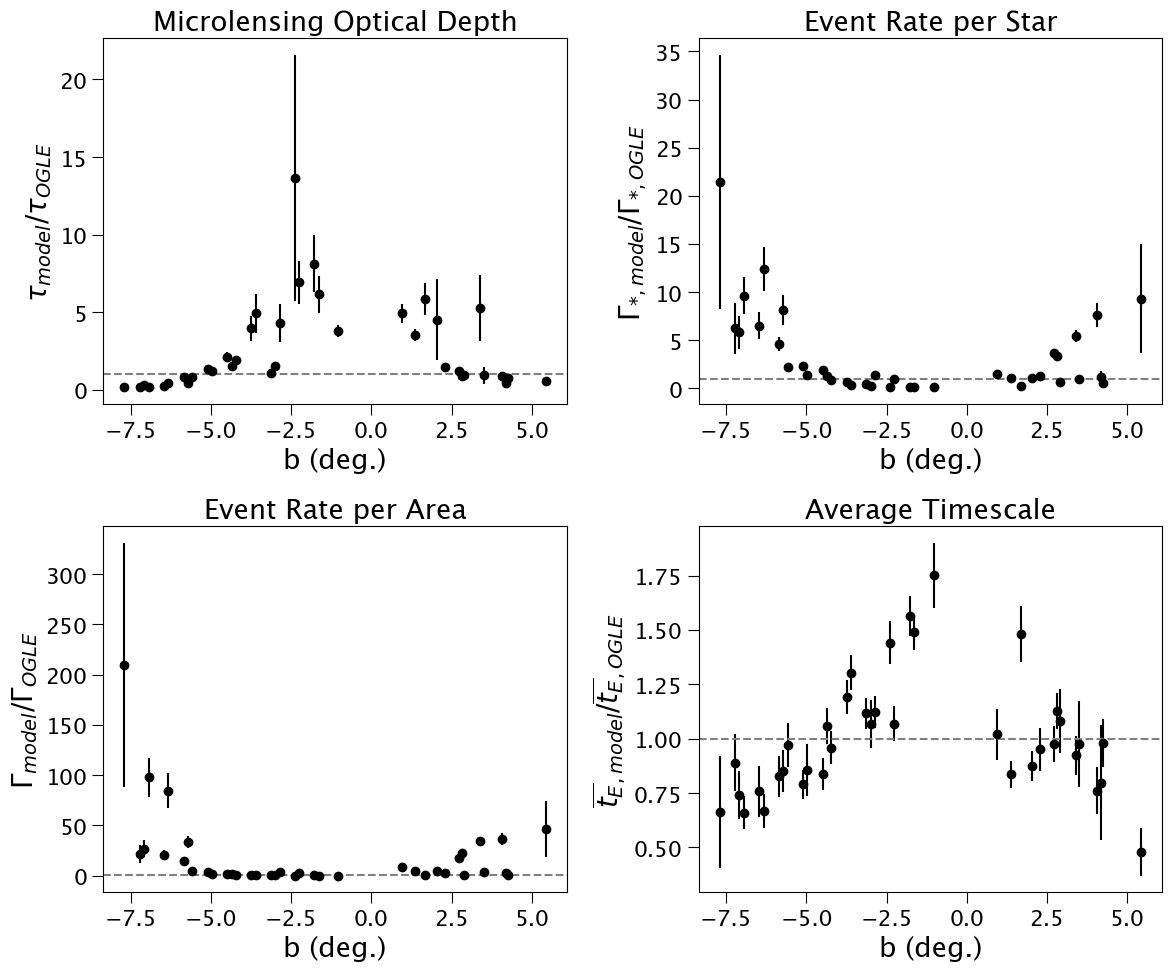

In [27]:
b_pts = np.arange(-7,7.0001,0.1)
def tau_fit(b):
    return 1.36 * np.exp(0.39*(3-abs(b)))
def rt_fit(b):
    return 13.4 * np.exp(0.49*(3-abs(b)))

modlab='Model'; oglab=None

plt.subplots(nrows=2,ncols=2,figsize=(12,10))
plt.subplot(221)
plt.title('Microlensing Optical Depth')
plt.errorbar(sp_dat['b'], np.array(sp_dat['avg_tau'])*10**6/np.array(ogle_rates_sel['tau']), 
             yerr=ogle_rates_sel['e_tau']/ogle_rates_sel['tau']**2*np.array(sp_dat['avg_tau'])*10**6,
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel(r'$\tau_{model}/\tau_{OGLE}$'); plt.xlabel('b (deg.)')
plt.axhline(1, color='gray',linestyle='--')
#plt.ylim(0,6)
#plt.legend()

plt.subplot(222)
plt.title('Event Rate per Star')
plt.errorbar(ogle_rates_sel['GLAT'],np.array(sp_dat['eventrate_source'])*10**6/np.array(ogle_rates_sel['gam']), 
             yerr=ogle_rates_sel['e_gam']*np.array(sp_dat['eventrate_source'])*10**6/np.array(ogle_rates_sel['gam'])**2,
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel(r'$\Gamma_{*, model}/\Gamma_{*, OGLE}$'); plt.xlabel('b (deg.)')
plt.axhline(1, color='gray',linestyle='--')
#plt.legend()

plt.subplot(223)
plt.title('Event Rate per Area')
plt.errorbar(ogle_rates_sel['GLAT'],np.array(sp_dat['eventrate_area'])/ogle_rates_sel['gam-deg2'], 
             yerr=ogle_rates_sel['e_gam-deg2']*np.array(sp_dat['eventrate_area'])/ogle_rates_sel['gam-deg2']**2,
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel(r'$\Gamma_{model}/\Gamma_{OGLE}$'); plt.xlabel('b (deg.)')
plt.axhline(1, color='gray',linestyle='--')
#plt.ylim(0,60)
#plt.legend()

plt.subplot(224)
plt.title('Average Timescale')
plt.errorbar(ogle_rates_sel['GLAT'],np.array(sp_dat['avg_t'])/ogle_rates_sel['tE-mean'], 
             yerr=ogle_rates_sel['e_tE-mean']*np.array(sp_dat['avg_t'])/ogle_rates_sel['tE-mean']**2,
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel('$\overline{t_E}_{, model}/\overline{t_E}_{, OGLE}$'); plt.xlabel('b (deg.)')
plt.axhline(1, color='gray',linestyle='--')
#plt.ylim(0,60)
#plt.legend()
plt.tight_layout()

plt.savefig('figures/ogle_bdep_ratio.png')